### Gradient Boosting Regressor

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import GridSearchCV

In [2]:
concrete = pd.read_csv('concrete_data.csv')

concrete.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [3]:
X = concrete.drop('csMPa', axis=1)

Y = concrete['csMPa']

In [4]:
# droping from features 
X = X.drop(['flyash', 'coarseaggregate', 'fineaggregate'], axis=1)

In [5]:
# set up training data and subset test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [6]:
model = GradientBoostingRegressor(max_depth=3, n_estimators=50)
model.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [7]:
# check performances of the model 
y_pred = model.predict(x_test)

r2_score(y_test, y_pred)

0.862960083121568

In [8]:
important_features = pd.Series(model.feature_importances_, index=X.columns).\
                        sort_values(ascending=False)

important_features

age                 0.386134
cement              0.346196
water               0.102538
slag                0.088940
superplasticizer    0.076193
dtype: float64

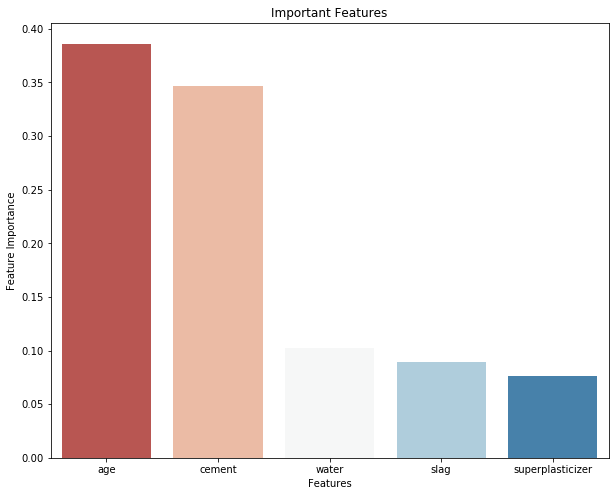

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot( x = important_features.index, y = important_features, palette = "RdBu")

plt.xlabel('Features')
plt.ylabel('Feature Importance')

plt.title("Important Features")
plt.show()

In [10]:
gbr = GradientBoostingRegressor(max_depth=3)

In [11]:
# Tuning to determine the best n_estimators parameter
parameters = {'n_estimators': [1, 5, 10, 50, 100, 200, 300, 400, 500]}

gridsearch_reg = GridSearchCV(estimator=gbr, param_grid=parameters, cv=3)

In [12]:
gridsearch_reg.fit(x_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                 

In [13]:
gridsearch_reg.best_params_

{'n_estimators': 500}

In [14]:
# shuffle the data and resplit 
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [16]:
# train a model with the parameter returned by gridsearch
gbr_best = GradientBoostingRegressor(max_depth=3, 
                                n_estimators = gridsearch_reg.best_params_['n_estimators'])

gbr_best.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [17]:
y_pred = gbr_best.predict(x_test)

r2_score(y_test, y_pred)

0.9249767329264036

In [18]:
gbr = GradientBoostingRegressor(max_depth=3, warm_start=True)

### Tuning for n_estimators
warm_start=True  allows you to add more estimators to an already fitted model.

In [19]:
# Early stop to find optimal number of trees to use in the ensemble

# keep track of the error values of the ensemble to see what the min err values is 
min_val_error = float("inf")
error_increasing = 0 # keep track of how many times in sequence the error values increase as estimators are added 

# set up for loop that goes from 1 to 999 (adds one estimator at a time)
for n_estimators in range(1, 1000):
    gbr.n_estimators = n_estimators
    gbr.fit(x_train, y_train)
    
    #evaluate the model
    y_pred = gbr.predict(x_test)
    val_error = mean_squared_error(y_test, y_pred)
    
    print('No. of estimators: ', gbr.n_estimators_)
    print('Validation error: ', val_error)
    
    # update the validation error and reinitialize error_increasing to zero
    if val_error < min_val_error:
        min_val_error = val_error
        error_increasing = 0
        
    # increment the error_increasing if the last 10 predictors has not improved we stop 
    else:
        error_increasing += 1
        if error_increasing == 10:
            break

No. of estimators:  1
Validation error:  244.86718421074676
No. of estimators:  2
Validation error:  220.53357408030783
No. of estimators:  3
Validation error:  198.53729000118273
No. of estimators:  4
Validation error:  179.07234788100158
No. of estimators:  5
Validation error:  164.4475661538717
No. of estimators:  6
Validation error:  150.19551437315002
No. of estimators:  7
Validation error:  137.61960936566084
No. of estimators:  8
Validation error:  127.95685593668952
No. of estimators:  9
Validation error:  119.09852765986982
No. of estimators:  10
Validation error:  110.76449621160607
No. of estimators:  11
Validation error:  104.09096714968584
No. of estimators:  12
Validation error:  97.93763280681186
No. of estimators:  13
Validation error:  92.08220559117554
No. of estimators:  14
Validation error:  87.72698294553172
No. of estimators:  15
Validation error:  83.0805339831284
No. of estimators:  16
Validation error:  78.2704703615136
No. of estimators:  17
Validation error: 

In [20]:
n_estimators

290

roughly 290 estimators give a good model 

##### to train a model with that number of estimators shuffle and resplit the data 
##### instantiate GBR with n_estimators = 290

In [21]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [22]:
gbr_best = GradientBoostingRegressor(max_depth=3,
                                     n_estimators = n_estimators)

In [23]:
gbr_best.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=290,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [24]:
y_pred = gbr_best.predict(x_test)

r2_score(y_test, y_pred)

0.9329719267340315